In [ ]:
import cv2
import cv_exp.basic
import cv_exp.basic as cv
import cv_exp.pupil_detection as pupil_detection
import cv_exp.draw as draw
import cv_exp.log as log
import cv_exp.take as take
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
from PIL import Image
import pandas as pd
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
import plotly.express as px


model_face_detection = '/home/roopesh/Desktop/MediaPipe_new_cv_exp/cv-exp-framework-master/data/models/face_detection_front.tflite'
model_face_landmarks ='/home/roopesh/Desktop/MediaPipe_new_cv_exp/cv-exp-framework-master/data/models/face_landmark.tflite'
model_iris_landmarks = '/home/roopesh/Desktop/MediaPipe_new_cv_exp/cv-exp-framework-master/data/models/iris_landmark.tflite'

iris_detector = pupil_detection.IrisDetectorMP(model_face_detection_path=model_face_detection,
                                                   model_face_landmarks_path=model_face_landmarks,
                                                   model_iris_landmarks_path=model_iris_landmarks)

def Mediapipe_Iris_Color(path):
    '''

    This function takes the image in path and Using Mediapipe calculates the Annular Mask of the images,
    then calculates the HSV color of Annular mask.
    and returns the dominant Iris colour percentage in a data frame.

    '''

    image = cv2.imread(path)
    image_bgr_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # converting from BGR to RGB
    out_ = image_bgr_rgb.copy()
    out_pupile_ = image_bgr_rgb.copy()
    result = iris_detector.detect(image_bgr_rgb)

    if not result is None:

        detected_pupils = result.detected_pupils,
        face_rect_detection = result.face_rect_detection_from_landmarks,
        face_rect_landmarks = result.face_rect_from_landmarks,
        face_landmarks = result.face_landmarks,
        face_rect_detection_from = result.face_rect_from_detection,
        face_landmarks_from_detection = result.face_landmarks_from_detection,
        left_iris_landmarks = result.left_iris_landmarks,
        left_eyelid_landmarks = result.left_eyelid_landmarks,
        right_iris_landmarks = result.right_iris_landmarks,
        right_eyelid_landmarks = result.right_eyelid_landmarks,
        left_iris_segmentation = result.left_iris_segmentation,
        right_iris_segmentation = result.right_iris_segmentation,
        eyes_landmarks = result.eyes_landmarks

        # drawing (Optional)

        out_pupile_ = draw.draw_pupils(out_pupile_, result.detected_pupils.left, result.detected_pupils.right, color_center = (255, 255, 255), color_contour = (255, 255, 255))
        out_pupile_ = draw.draw_rect(out_pupile_, result.face_rect_detection_from_landmarks, thickness=6, color=(255, 0, 0))
        out_pupile_ = draw.draw_list_pointd(out_pupile_, result.left_iris_landmarks,radius=6,color = (255, 255, 255))
        out_pupile_= draw.draw_contour(out_pupile_, result.left_iris_segmentation,  thickness=1,color=(0, 0, 255))
        out_pupile_ = draw.draw_list_pointd(out_pupile_, result.left_eyelid_landmarks,radius=6,color = (255, 0, 0))

        # Extraction of specific Points From Left Iris Landmarks (0,1) : Left Iris from Coder's Point of view

        left_iris_tuple_of_tuple_Tolist = ([PointD_elements for PointD in right_eyelid_landmarks for PointD_elements in PointD])
        left_iris_points = [(pointD.x, pointD.y) for pointD in left_iris_tuple_of_tuple_Tolist]

        center_point_LeftIris=(np.round(left_iris_points[0]))
        for left_center_x,left_center_y in [center_point_LeftIris]:
             lx, ly = left_center_x,left_center_y

        left_point_LeftIris=(np.round(left_iris_points[1]))
        for leftIris_left_x,LeftIris_left_y in [left_point_LeftIris]:
            LIL_x, LIL_y = leftIris_left_x, LeftIris_left_y

        right_point_LeftIris=(np.round(left_iris_points[3]))
        for rightIris_x,rightIris_y in [right_point_LeftIris]:
            RIL_x, RIL_y = rightIris_x, rightIris_y

        Top_point_LeftIris=(np.round(left_iris_points[2]))
        for TopIris_x,TopIris_y in [Top_point_LeftIris]:
            TI_x, TI_y = TopIris_x, TopIris_y

        # Bottom_point_LeftIris=(np.round(left_iris_points[4]))
        # for BottomIris_x,BottomIris_y in [Bottom_point_LeftIris]:
        #     BI_x, BI_y = BottomIris_x, BottomIris_y


        # Distance Formula to calculate the distance between center to left_Iris_ points to get radius of iris
        distance_left_iris_center = np.sqrt((lx - LIL_x) ** 2 + (ly - LIL_y) ** 2)

        # First Circular mask for entire iris

        mask = np.zeros(out_pupile_.shape, dtype=np.uint8)      # Result from Mediapipe added here.
        center = (int(lx), int(ly))
        radius = (int((distance_left_iris_center) * 0.80))
        left_mask = cv2.circle(mask, center, radius,[255,255,255], -1 )
        result = cv2.bitwise_and(out_pupile_, left_mask)
        result[mask == 0] = 255                                 # adding background Color- white

        # cropping iris area from the first circular masked image

        x = int((RIL_x)+3)               # x-axis --Landmarks points from top- right point from left iris, +3 for adjusting the size
        y = int((TI_y)+3)                # y-axis --Landmarks points from top_ left of left iris, +3 for adjusting the size
        h = int(radius*2.35)-3               # height --Radius of iris times 2.35 for adjustment,-3 for adjustment
        w = int(radius*2.35)             # width  --Radius of iris times 2.35 for adjustment, -1 for adjustment
        crop = result[y:y+h, x:x+w]
        print(x,y,h,w)

        # second Circular mask to take inner pupil area alone

        mask1 = np.zeros(out_pupile_.shape, dtype=np.uint8)         # Result from Mediapipe added here for second mask.
        center1 = (int(lx), int(ly))
        radius1 = (int((distance_left_iris_center)* 0.50))          # to scrap pupil area and other reflection area
        left_mask1 = cv2.circle(mask1, center1, radius1, (255, 255, 255), -1 )
        result1 = cv2.bitwise_and(out_pupile_, left_mask1-255)      # subtracting white region over masked area
        result1[mask1 == 0] = 255                                   # adding background Color- white

        # Cropping the inner pupil area from the second circular masked image (size should be same as the first masked and cropped result )

        x = int(RIL_x)+3         # x-axis --Landmarks points from top- right point from left iris, +3 for adjusting the size
        y = int(TI_y)+3          # y-axis --Landmarks points from top_ left of left iris, +3 for adjusting the size
        h = int(radius*2.35)-3   # height --Radius of iris times 2.35,-3 for adjustment
        w = int(radius*2.35)     # width  --Radius of iris times 2.35, -1 for adjustment
        crop1 = result1[y:y+h, x:x+w]

        # Bitwise and operation to omit the inner pupil alone and take the rest of the iris area

        adding_both_cropped_image = cv2.bitwise_and(crop, crop1)

        # Removing NOISE from the Adding_both_cropped_image (<=10,  >=240) in all channel

        final_result = np.array(adding_both_cropped_image)
        mask = np.all(final_result <= [10, 10, 10], axis=2)
        final_result[mask] = [0, 0, 0]
        mask = np.all(final_result >= [240, 240, 240], axis=2)
        final_result[mask] = [0, 0, 0]
        annular_result = final_result                   # the final result of the iris area from mediapipe

        # Additional Cropping the iris masked from the Annular_result to make 3 sub cropped images

        x, y = final_result.shape[:2]
        half = x//2
        top_third_= x//3
        Upper_Third = final_result[:top_third_]               # Upper third of the image
        top_3 = final_result[top_third_:half]
        bottom = final_result[half:]
        x1, y1 = bottom.shape[:2]
        bottom_third = x1//3
        bo_3 = bottom[:bottom_third]
        half1 = x1//3
        Lower_Third = bottom[half1:]                          # Lower third of the image
        Middle_Third = np.vstack((top_3, bo_3))               # middle third of the image

        cv2.imshow('Upper_Third', Upper_Third)
        cv2.imshow('Middle_Third', Middle_Third)
        cv2.imshow('Lower_Third', Lower_Third)
        cv2.waitKey(delay=0)
        cv2.destroyAllWindows()

        dict1 = dict()
        dict1['Upper_Third'] = Upper_Third
        dict1['Middle_Third'] = Middle_Third
        dict1['Lower_Third'] = Lower_Third

        # Printing the cropped iris area from the Annular_result (optional)

        annular_result1 = cv2.cvtColor(annular_result, cv2.COLOR_RGB2BGR)
        Upper_Third1 = cv2.cvtColor(Upper_Third, cv2.COLOR_RGB2BGR)
        Middle_Third1 = cv2.cvtColor(Middle_Third, cv2.COLOR_RGB2BGR)
        Lower_Third1 = cv2.cvtColor(Lower_Third, cv2.COLOR_RGB2BGR)

        out_pupile_1 = cv2.cvtColor(out_pupile_, cv2.COLOR_RGB2BGR)
        out_pupile_1 = cv2.putText(out_pupile_1, "Right Iris", (int(TI_x), int(TI_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/annular_Iris_Right/{file}',annular_result1)
        cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Iris_original_/{file}',out_pupile_1)
        cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Upper_Third_Right/{file}',Upper_Third1)
        cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Middle_Third_Right/{file}',Middle_Third1)
        cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Lower_Third_Right/{file}',Lower_Third1)

         #   Reading Image in PIL format for dominant color detection.

        dominantColour = []

        for keys, values in dict1.items():
            pil_image = Image.fromarray(values)
            imarray = np.array(pil_image.getdata())
            df = pd.DataFrame(imarray, columns=['RED', 'GREEN', 'BLUE'])
            df = pd.DataFrame(df[(df['RED'] >= 50) | (df['GREEN'] >= 50) | (df['BLUE'] >= 50)])  # For value greater than 50

             # K-Means Clustering using Scipy

            cluster_size = 3
            cluster_centers, _ = kmeans(df.values.astype(float), cluster_size)
            index, _ = vq(df.values.astype(float), cluster_centers)
            count = np.bincount(index)
            sum = np.sum(count)
            i, Blue, Green, Brown, Other = 0, 0, 0, 0, 0
            for row in cluster_centers:
                r = row[0]
                g = row[1]
                b = row[2]
                h, s, v = rgb_to_hsv(r, g, b)   # calling the function to convert RGB to HSV
                percent = count[i]*100/sum
                if h >= 170 and h < 270:
                    Blue += percent
                elif h >= 60 and h < 170:
                    Green += percent
                elif h >= 300 or h < 40:
                    Brown += percent
                else:
                    Other += percent
                i+=1

            # Results of Dominant Color Detection in dataframe

            data = [[file, str(keys), int(Blue), int(Green), int(Brown), int(Other) ,'.']]
            dominantColour_ = pd.DataFrame(data, columns=['File_name :', 'Image Position :', 'Blue % :', 'Green % :', 'Brown % :','Other % :','.']).T
            dominantColour.append(dominantColour_)

        return dominantColour

    else: print("No face detected :", file)

     # **************************  END of Dominant Colour Detection **************************


def rgb_to_hsv(r, g, b):
    '''
    Convert RGB to HSV
    returns h,s,v
    '''

    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v

if __name__ == '__main__':

   # ----------Load Image Directory -------------

   # images_files_dir= '/home/roopesh/Desktop/New_Corpus/test/'

   # images_files_dir= '/home/roopesh/Desktop/new_cvexp_results/V2.0/New_Green_Eyes/Green_Iris_Training_Image/' # Directory of the images

   # images_files_dir= '/home/roopesh/Desktop/New_Corpus_v3/Blue/'
   # images_files_dir= '/home/roopesh/Desktop/New_Corpus_v3/Green/'
   images_files_dir= '/home/roopesh/Desktop/New_Corpus_v3/Brown/'
   # images_files_dir= '//home/roopesh/Desktop/test/'


   files = os.listdir(images_files_dir)

   for idx, file in enumerate(files):
        image_path = images_files_dir + file
        mediapipe_iris_color_chart = Mediapipe_Iris_Color(image_path)           # Calling the Mediapipe_Iris_Color(image_path)
        print(mediapipe_iris_color_chart)




2554 2327 72 75


([<PointD (2362.4032511343626,2254.9322158837012)>, <PointD (2291.98639890515,2245.610423035753)>, <PointD (2372.6264823238585,2189.3799139648045)>, <PointD (2433.8832080947764,2263.9223119770386)>, <PointD (2352.522889319323,2320.3150934191804)>],)
2362.0 2255.0 2292.0 2246.0 2434.0 2264.0 2373.0 2189.0



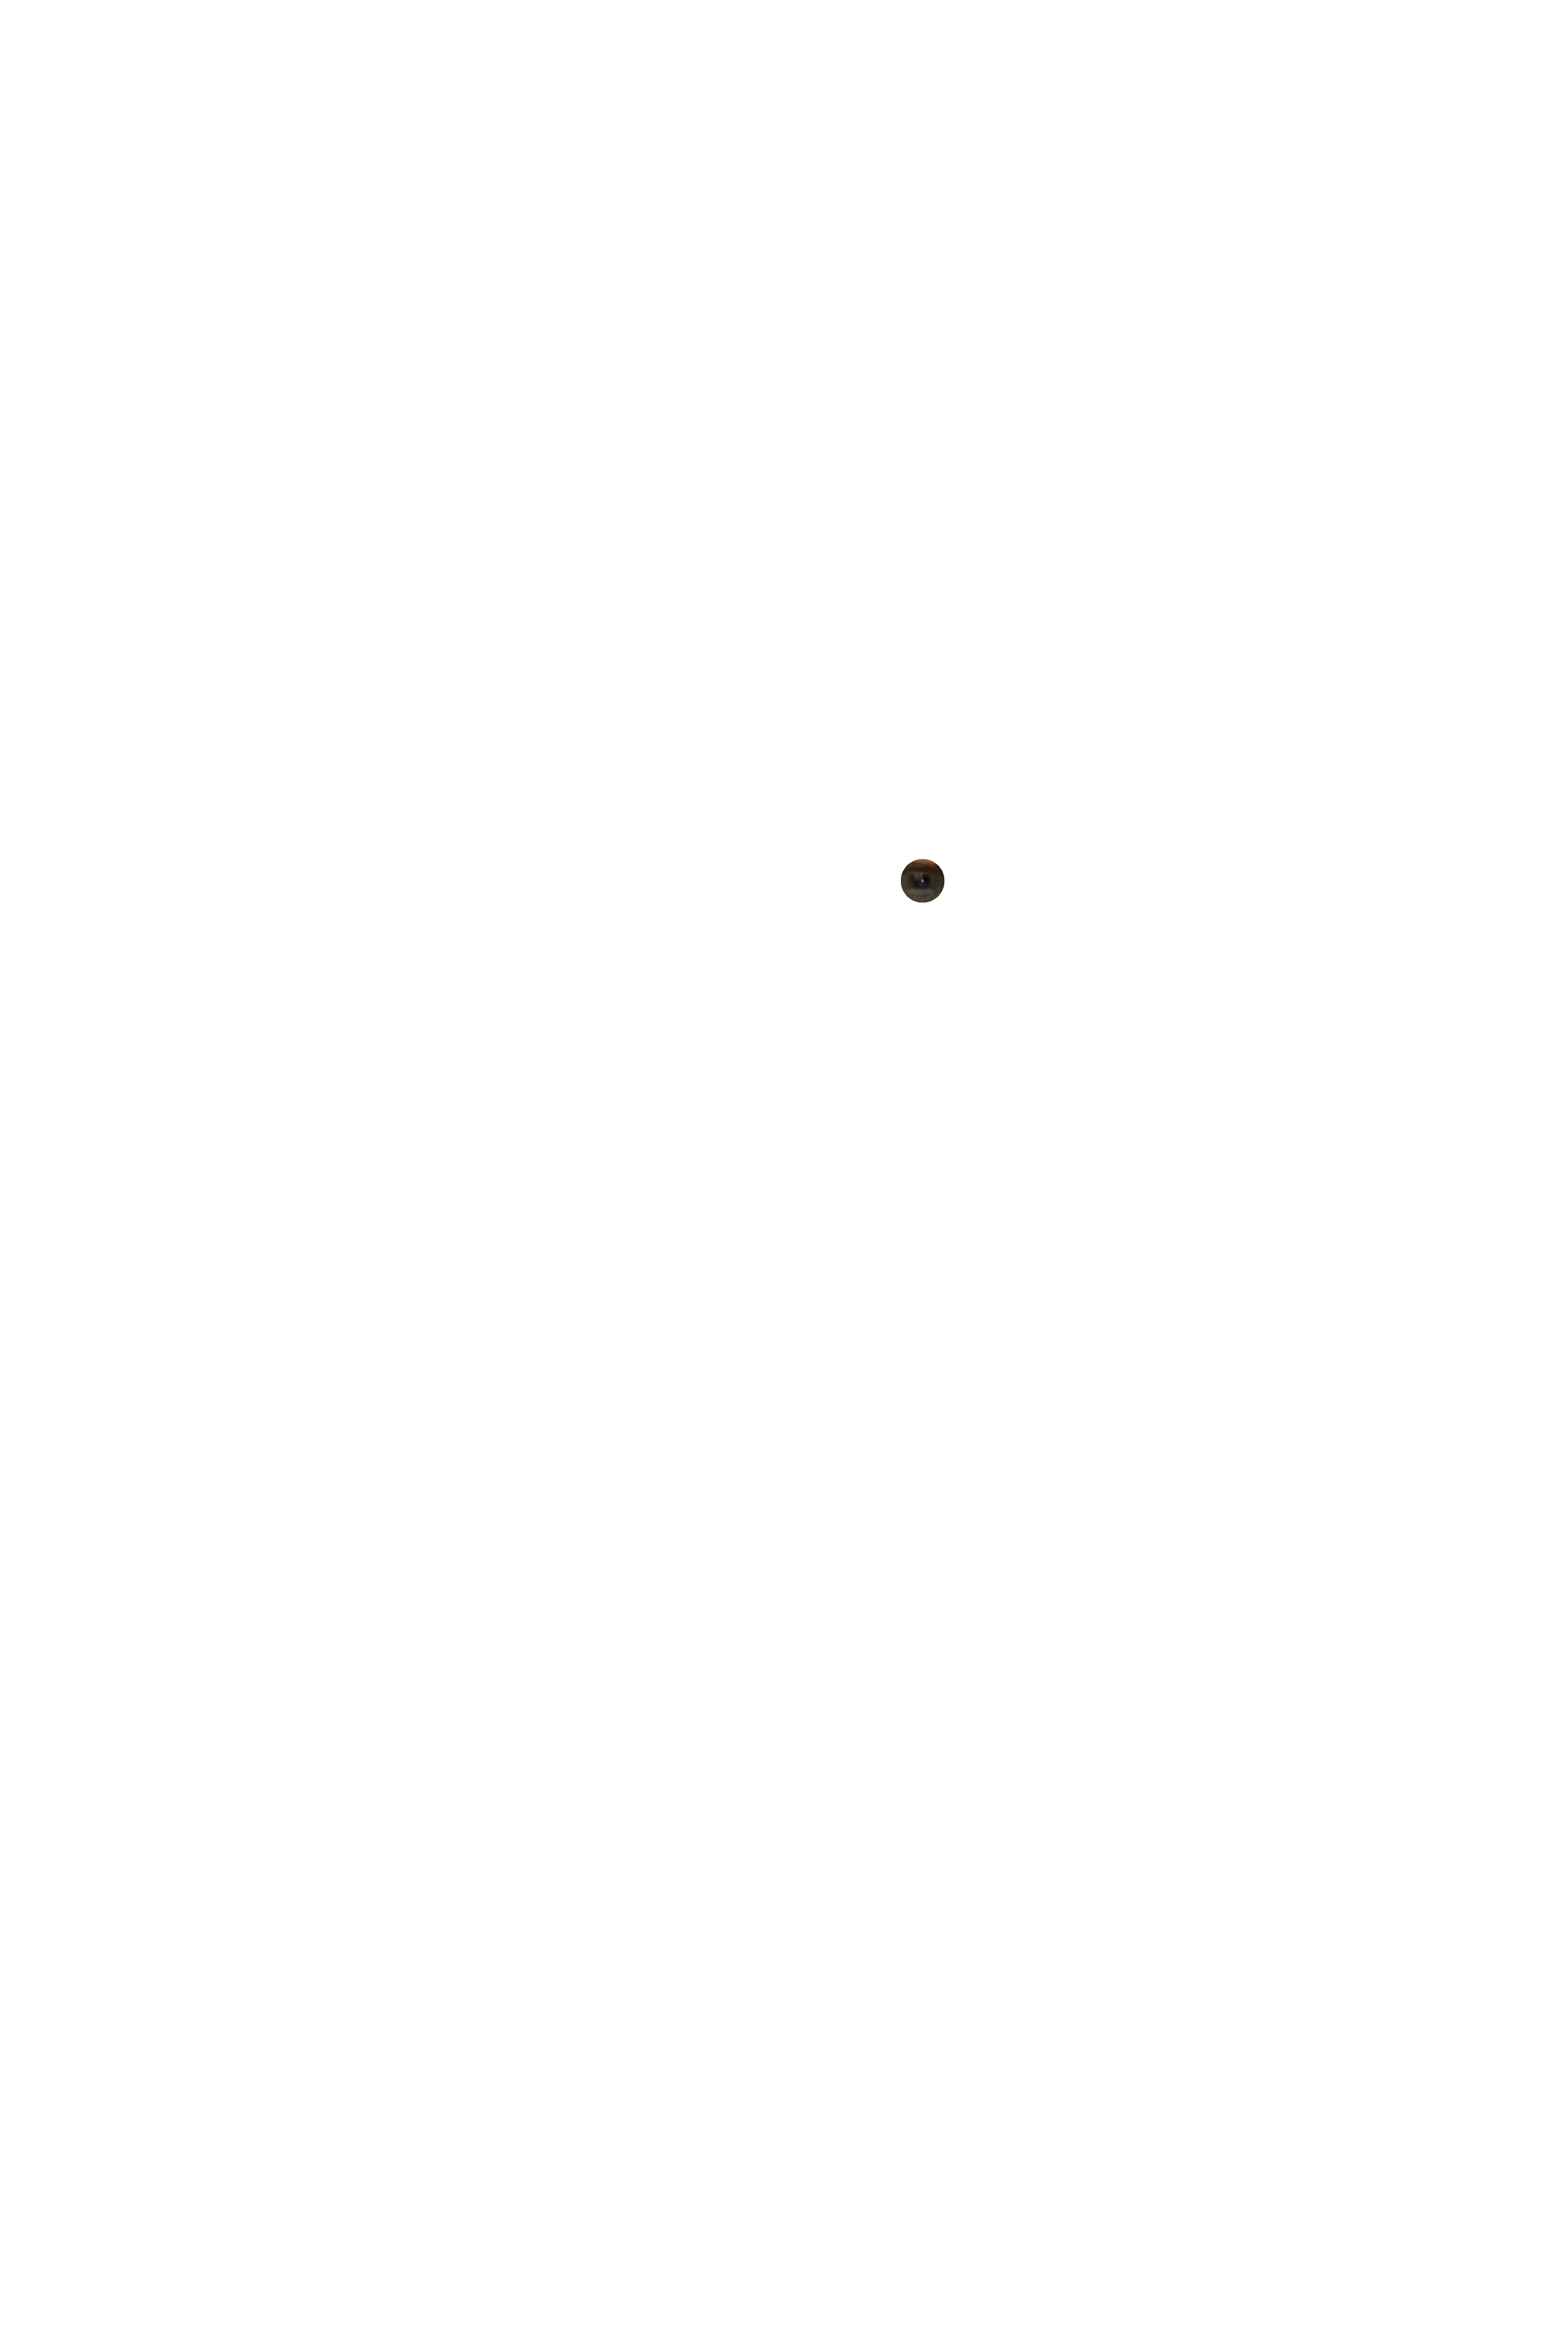

In [17]:
import cv2
import cv_exp.basic
import cv_exp.basic as cv
import cv_exp.pupil_detection as pupil_detection
import cv_exp.draw as draw
import cv_exp.log as log
import cv_exp.take as take
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
from PIL import Image
import pandas as pd
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
import plotly.express as px


model_face_detection = '/home/roopesh/Desktop/MediaPipe_new_cv_exp/cv-exp-framework-master/data/models/face_detection_front.tflite'
model_face_landmarks ='/home/roopesh/Desktop/MediaPipe_new_cv_exp/cv-exp-framework-master/data/models/face_landmark.tflite'
model_iris_landmarks = '/home/roopesh/Desktop/MediaPipe_new_cv_exp/cv-exp-framework-master/data/models/iris_landmark.tflite'

iris_detector = pupil_detection.IrisDetectorMP(model_face_detection_path=model_face_detection,
                                                   model_face_landmarks_path=model_face_landmarks,
                                                   model_iris_landmarks_path=model_iris_landmarks)



def rgb_to_hsv(r, g, b):
    '''
    Convert RGB to HSV
    returns h,s,v
    '''

    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v



path='/home/roopesh/Desktop/New_Corpus/test/front (4).jpg'
file=str('file')
image = cv2.imread(path)
image_bgr_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # converting from BGR to RGB
out_ = image_bgr_rgb.copy()
out_pupile_ = image_bgr_rgb.copy()
result = iris_detector.detect(image_bgr_rgb)

if not result is None:

    detected_pupils = result.detected_pupils,
    face_rect_detection = result.face_rect_detection_from_landmarks,
    face_rect_landmarks = result.face_rect_from_landmarks,
    face_landmarks = result.face_landmarks,
    face_rect_detection_from = result.face_rect_from_detection,
    face_landmarks_from_detection = result.face_landmarks_from_detection,
    left_iris_landmarks = result.left_iris_landmarks,
    left_eyelid_landmarks = result.left_eyelid_landmarks,
    right_iris_landmarks = result.right_iris_landmarks,
    right_eyelid_landmarks = result.right_eyelid_landmarks,
    left_iris_segmentation = result.left_iris_segmentation,
    right_iris_segmentation = result.right_iris_segmentation,
    eyes_landmarks = result.eyes_landmarks

    # drawing (Optional)

    out_pupile_ = draw.draw_pupils(out_pupile_, result.detected_pupils.left, result.detected_pupils.right, color_center = (255, 255, 255), color_contour = (255, 255, 255))
    out_pupile_ = draw.draw_rect(out_pupile_, result.face_rect_detection_from_landmarks, thickness=6, color=(255, 0, 0))
    out_pupile_ = draw.draw_list_pointd(out_pupile_, result.left_iris_landmarks,radius=6,color = (255, 255, 255))
    out_pupile_= draw.draw_contour(out_pupile_, result.left_iris_segmentation,  thickness=1,color=(0, 0, 255))
    out_pupile_ = draw.draw_list_pointd(out_pupile_, result.left_eyelid_landmarks,radius=6,color = (255, 0, 0))
    
    print(right_iris_landmarks)

    # Extraction of specific Points From Left Iris Landmarks (0,1) : Left Iris from Coder's Point of view

    left_iris_tuple_of_tuple_Tolist = ([PointD_elements for PointD in right_iris_landmarks for PointD_elements in PointD])
    left_iris_points = [(pointD.x, pointD.y) for pointD in left_iris_tuple_of_tuple_Tolist]

    center_point_LeftIris=(np.round(left_iris_points[0]))
    for left_center_x,left_center_y in [center_point_LeftIris]:
         lx, ly = left_center_x,left_center_y

    left_point_LeftIris=(np.round(left_iris_points[1]))
    for leftIris_left_x,LeftIris_left_y in [left_point_LeftIris]:
        LIL_x, LIL_y = leftIris_left_x, LeftIris_left_y

    right_point_LeftIris=(np.round(left_iris_points[3]))
    for rightIris_x,rightIris_y in [right_point_LeftIris]:
        RIL_x, RIL_y = rightIris_x, rightIris_y

    Top_point_LeftIris=(np.round(left_iris_points[2]))
    for TopIris_x,TopIris_y in [Top_point_LeftIris]:
        TI_x, TI_y = TopIris_x, TopIris_y

    Bottom_point_LeftIris=(np.round(left_iris_points[4]))
    for BottomIris_x,BottomIris_y in [Bottom_point_LeftIris]:
         BI_x, BI_y = BottomIris_x, BottomIris_y
    
    
    print(lx, ly,LIL_x, LIL_y,RIL_x, RIL_y,TI_x, TI_y)


    # Distance Formula to calculate the distance between center to left_Iris_ points to get radius of iris
    distance_left_iris_center = np.sqrt((lx - LIL_x) ** 2 + (ly - LIL_y) ** 2)

    # First Circular mask for entire iris

    mask = np.zeros(out_pupile_.shape, dtype=np.uint8)      # Result from Mediapipe added here.
    center = (int(lx), int(ly))
    radius = (int((distance_left_iris_center) * 0.80))
    left_mask = cv2.circle(mask, center, radius,[255,255,255], -1 )
    result = cv2.bitwise_and(out_pupile_, left_mask)
    result[mask == 0] = 255  
    
    fig=px.imshow(result)
    fig.show()
    
   
    

#else: print("No face detected :", file)

 # **************************  END of Dominant Colour Detection **************************





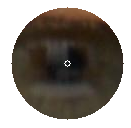

In [25]:
# cropping iris area from the first circular masked image

x = int((LIL_x)+3)               # x-axis --Landmarks points from top- right point from left iris, +3 for adjusting the size
y = int((TI_y)+3)                # y-axis --Landmarks points from top_ left of left iris, +3 for adjusting the size
h = int(radius*2.35)-3               # height --Radius of iris times 2.35 for adjustment,-3 for adjustment
w = int(radius*2.35)             # width  --Radius of iris times 2.35 for adjustment, -1 for adjustment
crop = result[y:y+h, x:x+w]

fig=px.imshow(crop)
fig.show()





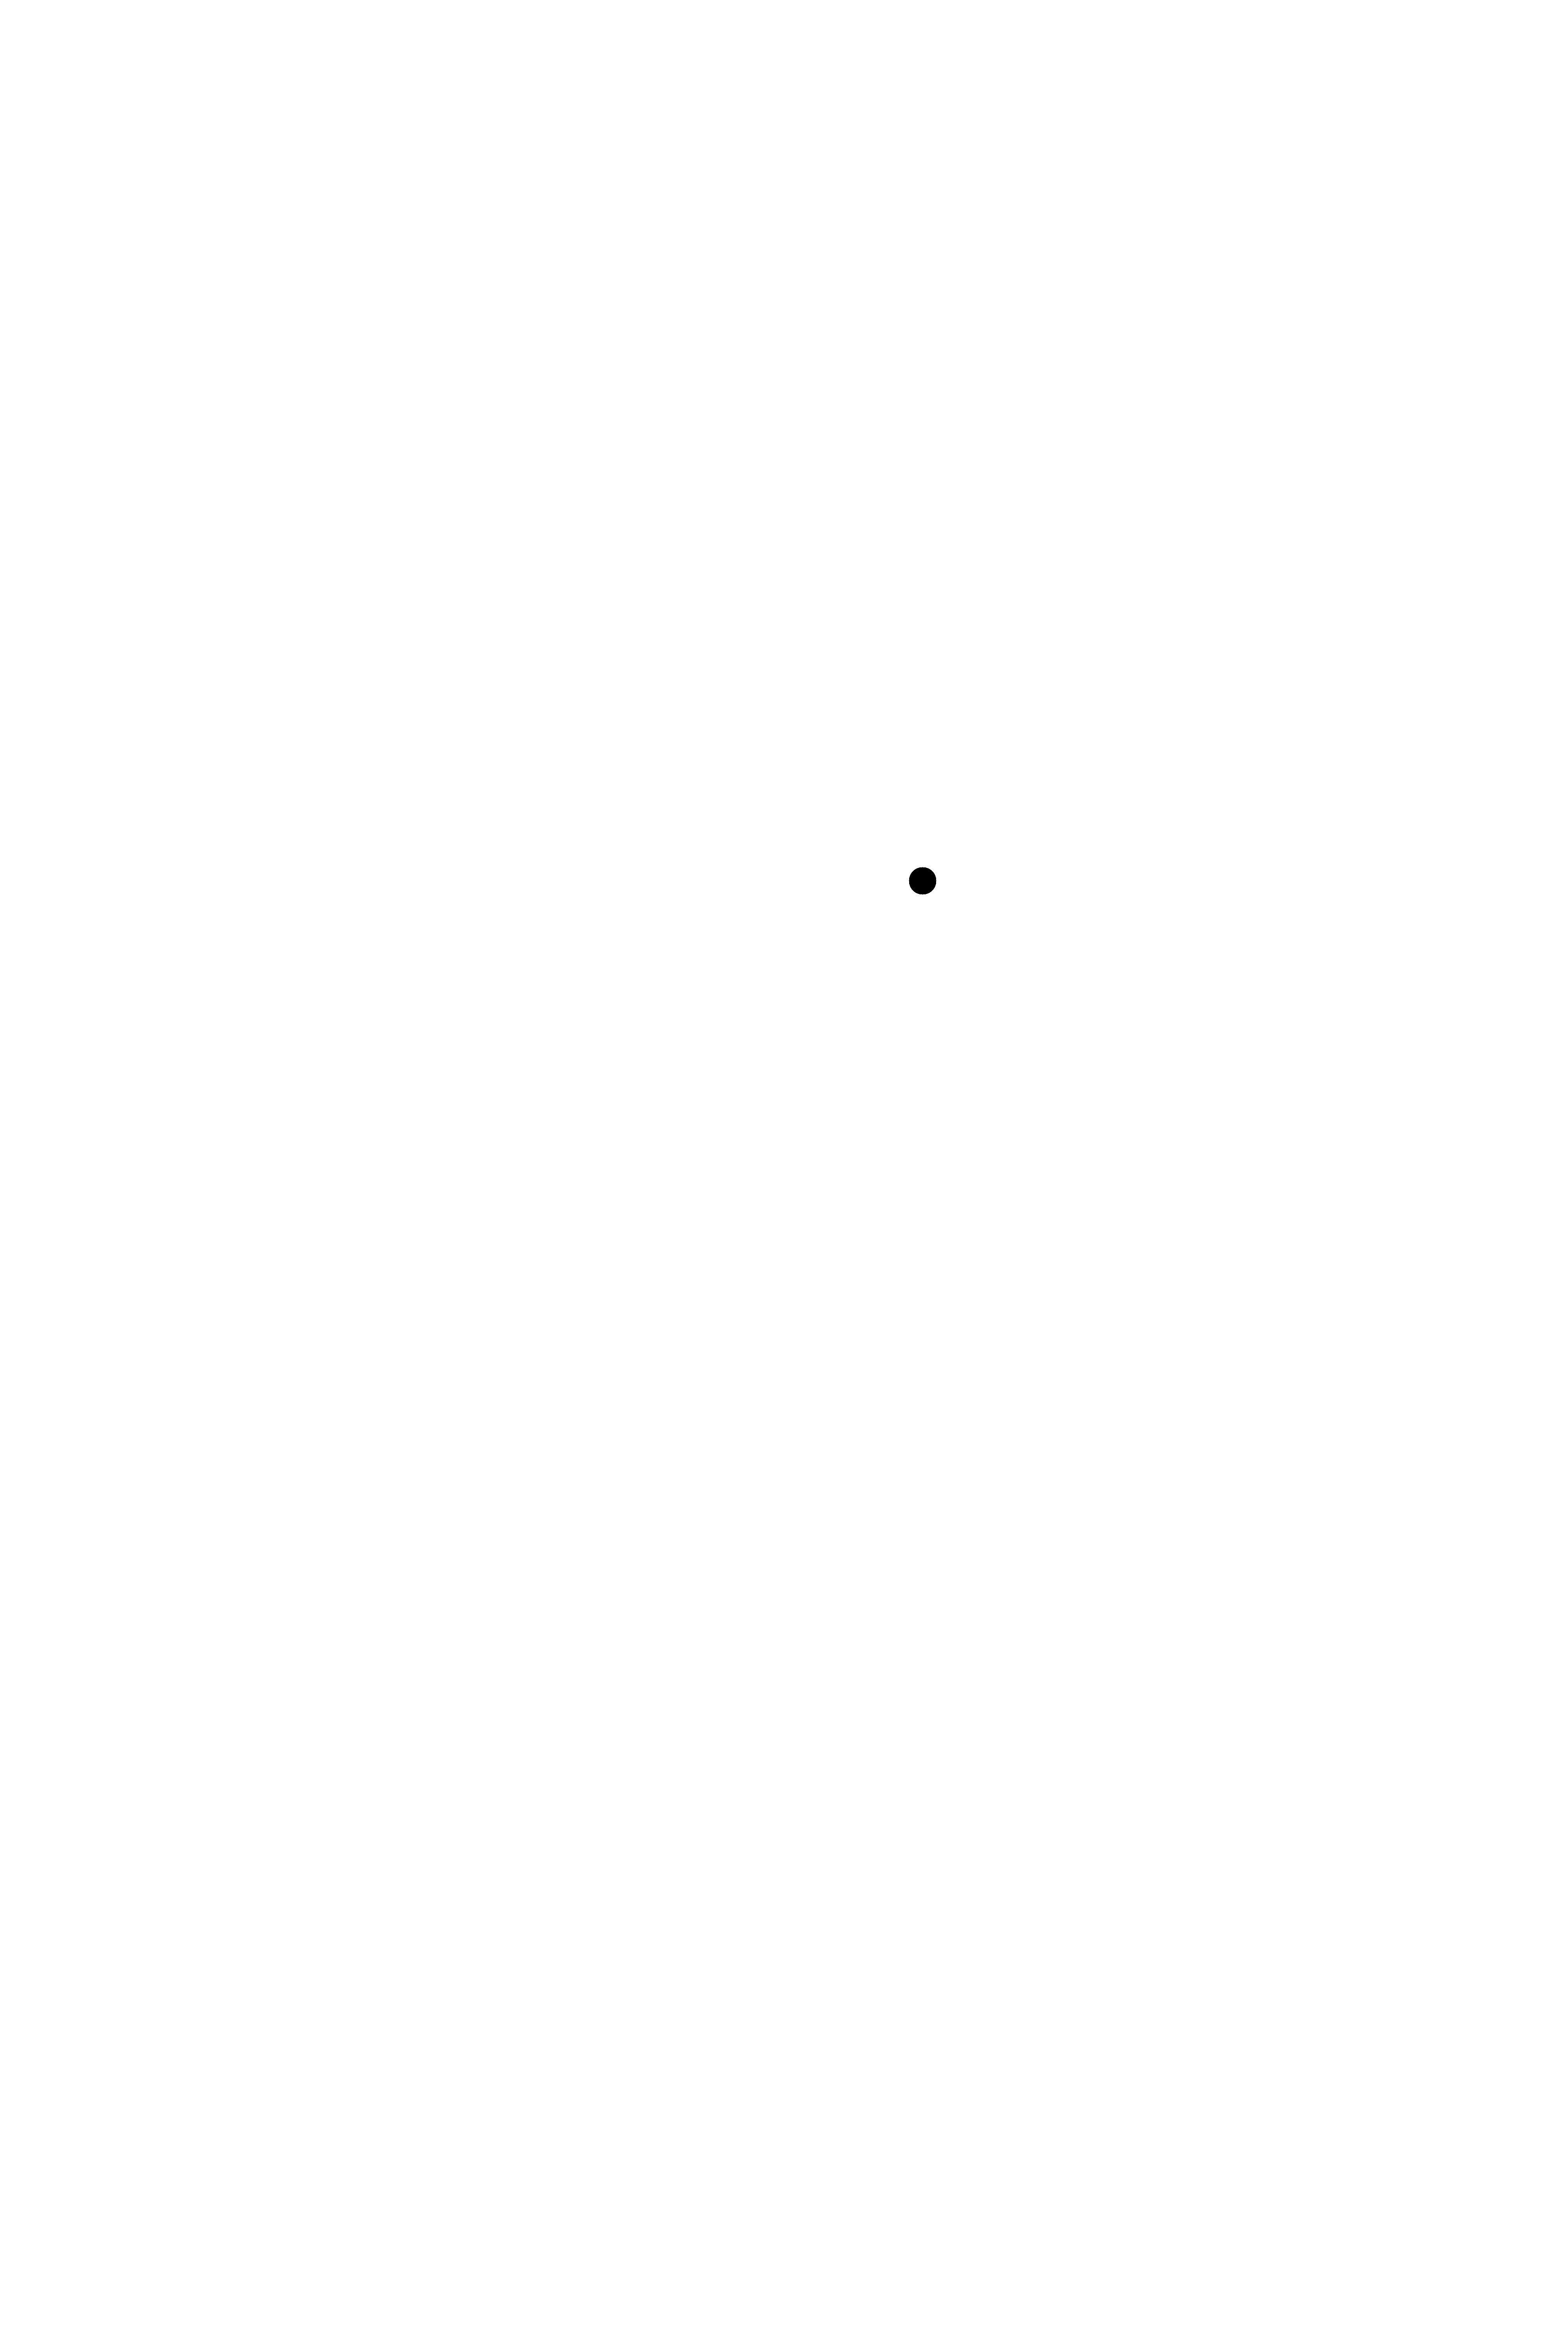

In [27]:
# second Circular mask to take inner pupil area alone

mask1 = np.zeros(out_pupile_.shape, dtype=np.uint8)         # Result from Mediapipe added here for second mask.
center1 = (int(lx), int(ly))
radius1 = (int((distance_left_iris_center)* 0.50))          # to scrap pupil area and other reflection area
left_mask1 = cv2.circle(mask1, center1, radius1, (255, 255, 255), -1 )
result1 = cv2.bitwise_and(out_pupile_, left_mask1-255)      # subtracting white region over masked area
result1[mask1 == 0] = 255                                   # adding background Color- white

fig= px.imshow(result1)
fig.show()




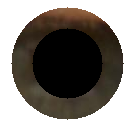

In [29]:
# Cropping the inner pupil area from the second circular masked image (size should be same as the first masked and cropped result )

x = int(LIL_x)+3         # x-axis --Landmarks points from top- right point from left iris, +3 for adjusting the size
y = int(TI_y)+3          # y-axis --Landmarks points from top_ left of left iris, +3 for adjusting the size
h = int(radius*2.35)-3   # height --Radius of iris times 2.35,-3 for adjustment
w = int(radius*2.35)     # width  --Radius of iris times 2.35, -1 for adjustment
crop1 = result1[y:y+h, x:x+w]

# Bitwise and operation to omit the inner pupil alone and take the rest of the iris area

adding_both_cropped_image = cv2.bitwise_and(crop, crop1)

fig= px.imshow(adding_both_cropped_image)
fig.show()




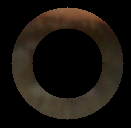

In [30]:
# Removing NOISE from the Adding_both_cropped_image (<=10,  >=240) in all channel

final_result = np.array(adding_both_cropped_image)
mask = np.all(final_result <= [10, 10, 10], axis=2)
final_result[mask] = [0, 0, 0]
mask = np.all(final_result >= [240, 240, 240], axis=2)
final_result[mask] = [0, 0, 0]
annular_result = final_result                   # the final result of the iris area from mediapipe

fig= px.imshow(annular_result )
fig.show()

In [32]:
# Additional Cropping the iris masked from the Annular_result to make 3 sub cropped images

x, y = final_result.shape[:2]
half = x//2
top_third_= x//3
Upper_Third = final_result[:top_third_]               # Upper third of the image
top_3 = final_result[top_third_:half]
bottom = final_result[half:]
x1, y1 = bottom.shape[:2]
bottom_third = x1//3
bo_3 = bottom[:bottom_third]
half1 = x1//3
Lower_Third = bottom[half1:]                          # Lower third of the image
Middle_Third = np.vstack((top_3, bo_3))               # middle third of the image


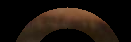

In [33]:
fig=px.imshow(Upper_Third)
fig.show()


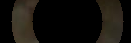

In [34]:
fig=px.imshow(Middle_Third)
fig.show()


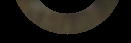

In [35]:
fig= px.imshow(Lower_Third)
fig.show()

In [49]:

dominantColour = []

for keys, values in dict1.items():
    pil_image = Image.fromarray(values)
    imarray = np.array(pil_image.getdata())
    df = pd.DataFrame(imarray, columns=['RED', 'GREEN', 'BLUE'])
    df = pd.DataFrame(df[(df['RED'] >= 50) | (df['GREEN'] >= 50) | (df['BLUE'] >= 50)])  # For value greater than 50
    data= df['RED'].count()
    print(data)
    
     # K-Means Clustering using Scipy

    cluster_size = 3
    cluster_centers, _ = kmeans(df.values.astype(float), cluster_size)
    index, _ = vq(df.values.astype(float), cluster_centers)
    count = np.bincount(index)
    sum = np.sum(count)
    i, Blue, Green, Brown, Other = 0, 0, 0, 0, 0
    for row in cluster_centers:
        r = row[0]
        g = row[1]
        b = row[2]
        h, s, v = rgb_to_hsv(r, g, b)   # calling the function to convert RGB to HSV
        percent = count[i]*100/sum
        if h >= 170 and h < 270:
            Blue += percent
        elif h >= 60 and h < 170:
            Green += percent
        elif h >= 300 or h < 40:
            Brown += percent
        else:
            Other += percent
        i+=1

    # Results of Dominant Color Detection in dataframe

    data = [[file, str(keys), int(Blue), int(Green), int(Brown), int(Other) ,'.']]
    dominantColour_ = pd.DataFrame(data, columns=['File_name :', 'Image Position :', 'Blue % :', 'Green % :', 'Brown % :','Other % :','.']).T
    dominantColour.append(dominantColour_)

print(dominantColour)

1450
1361
2057
[                            0
File_name :              file
Image Position :  Upper_Third
Blue % :                    0
Green % :                   0
Brown % :                 100
Other % :                   0
.                           .,                              0
File_name :               file
Image Position :  Middle_Third
Blue % :                     0
Green % :                    0
Brown % :                  100
Other % :                    0
.                            .,                             0
File_name :              file
Image Position :  Lower_Third
Blue % :                    0
Green % :                   0
Brown % :                  89
Other % :                  10
.                           .]


In [37]:
# Additional Cropping the iris masked from the Annular_result to make 3 sub cropped images

x, y = final_result.shape[:2]
half = x//2
top_third_= x//3
Upper_Third = final_result[:top_third_]               # Upper third of the image
top_3 = final_result[top_third_:half]
bottom = final_result[half:]
x1, y1 = bottom.shape[:2]
bottom_third = x1//3
bo_3 = bottom[:bottom_third]
half1 = x1//3
Lower_Third = bottom[half1:]                          # Lower third of the image
Middle_Third = np.vstack((top_3, bo_3))               # middle third of the image

cv2.imshow('Upper_Third', Upper_Third)
cv2.imshow('Middle_Third', Middle_Third)
cv2.imshow('Lower_Third', Lower_Third)
cv2.waitKey(delay=0)
cv2.destroyAllWindows()

dict1 = dict()
dict1['Upper_Third'] = Upper_Third
dict1['Middle_Third'] = Middle_Third
dict1['Lower_Third'] = Lower_Third

# Printing the cropped iris area from the Annular_result (optional)

annular_result1 = cv2.cvtColor(annular_result, cv2.COLOR_RGB2BGR)
Upper_Third1 = cv2.cvtColor(Upper_Third, cv2.COLOR_RGB2BGR)
Middle_Third1 = cv2.cvtColor(Middle_Third, cv2.COLOR_RGB2BGR)
Lower_Third1 = cv2.cvtColor(Lower_Third, cv2.COLOR_RGB2BGR)

out_pupile_1 = cv2.cvtColor(out_pupile_, cv2.COLOR_RGB2BGR)
out_pupile_1 = cv2.putText(out_pupile_1, "Right Iris", (int(TI_x), int(TI_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/annular_Iris_Right/{file}',annular_result1)
cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Iris_original_/{file}',out_pupile_1)
cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Upper_Third_Right/{file}',Upper_Third1)
cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Middle_Third_Right/{file}',Middle_Third1)
cv2.imwrite(f'/home/roopesh/Desktop/new_cvexp_results/V2.0/Lower_Third_Right/{file}',Lower_Third1)

 #   Reading Image in PIL format for dominant color detection.

dominantColour = []

for keys, values in dict1.items():
    pil_image = Image.fromarray(values)
    imarray = np.array(pil_image.getdata())
    df = pd.DataFrame(imarray, columns=['RED', 'GREEN', 'BLUE'])
    df = pd.DataFrame(df[(df['RED'] >= 50) | (df['GREEN'] >= 50) | (df['BLUE'] >= 50)])  # For value greater than 50

     # K-Means Clustering using Scipy

    cluster_size = 3
    cluster_centers, _ = kmeans(df.values.astype(float), cluster_size)
    index, _ = vq(df.values.astype(float), cluster_centers)
    count = np.bincount(index)
    sum = np.sum(count)
    i, Blue, Green, Brown, Other = 0, 0, 0, 0, 0
    for row in cluster_centers:
        r = row[0]
        g = row[1]
        b = row[2]
        h, s, v = rgb_to_hsv(r, g, b)   # calling the function to convert RGB to HSV
        percent = count[i]*100/sum
        if h >= 170 and h < 270:
            Blue += percent
        elif h >= 60 and h < 170:
            Green += percent
        elif h >= 300 or h < 40:
            Brown += percent
        else:
            Other += percent
        i+=1

    # Results of Dominant Color Detection in dataframe

    data = [[file, str(keys), int(Blue), int(Green), int(Brown), int(Other) ,'.']]
    dominantColour_ = pd.DataFrame(data, columns=['File_name :', 'Image Position :', 'Blue % :', 'Green % :', 'Brown % :','Other % :','.']).T
    dominantColour.append(dominantColour_)

print(dominantColour)

error: OpenCV(4.5.2) /tmp/pip-req-build-eirhwqtr/opencv/modules/imgcodecs/src/loadsave.cpp:650: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'
